# Data Load

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


5


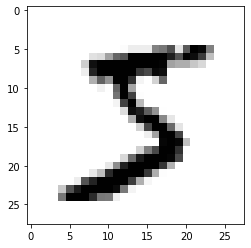

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_digit = X[0]
plt.imshow(sample_digit.reshape(28,28), cmap = 'binary')
print(y[0])

In [4]:
import numpy as np

y = y.astype(np.uint8)

Split train and test set. Since dataset is mixed already, we can split using just one index.

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

Make binary classifier that identifies number 5. Since SGDClassifiers handle each training samle independently, SGDClassifier can be a suitable model for a big data set and online training.

In [6]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [8]:
sgd_clf.predict(sample_digit.reshape(1,-1))

array([ True])

## Evaluation

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

Sometime, we are required to control cross validation process more than cross_val_score do. Then, we can make our own code as below.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_sgd = clone(sgd_clf)
    X_train_strat = X_train[train_idx]
    y_train_strat = y_train_5[train_idx]
    X_val_strat = X_train[test_idx]
    y_val_strat = y_train_5[test_idx]
    
    clone_sgd.fit(X_train_strat, y_train_strat)
    y_pred = clone_sgd.predict(X_val_strat)
    result_bool = (y_pred == y_val_strat)
    print(sum(result_bool) / len(y_pred))

c:\users\namte\.conda\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


When dataset is asymmetric, depending only on the accuracy is undesirable. Since dumb estimator whose prediction is always False can show high accracy as below.

In [14]:
from sklearn.base import BaseEstimator

class AlwaysFalseClassifier(BaseEstimator):
    def fit(self, X, y):
        return self
    def predict(self, X):
        return np.zeros(shape = (len(X),1), dtype = bool)

poor_clf = AlwaysFalseClassifier()
cross_val_score(poor_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

## ConfusionMatrix
* cross_val_predict: if cv= 3, we can split the train data into 3 sets(A,B,C). Then, predict A part when model is trained by B,C. And  predict B part when model is trained by A,C...

In [15]:
from sklearn.model_selection import cross_val_predict

y_val_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_val_pred

array([ True, False, False, ...,  True, False, False])

In [16]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_train_5, y_val_pred)
confusion_mat

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
from sklearn.metrics import recall_score, precision_score

print('precision score from sklearn packages: {0}'.format(precision_score(y_train_5, y_val_pred)))
print('precision score from confusion matrix: {0}'.format(confusion_mat[1,1] / (confusion_mat[0,1] + confusion_mat[1,1])))
print('recall score from sklearn packages: {0}'.format(recall_score(y_train_5, y_val_pred)))
print('recall score from confusion matrix: {0}'.format(confusion_mat[1,1] / (confusion_mat[1,0] + confusion_mat[1,1])))

precision score from sklearn packages: 0.8370879772350012
precision score from confusion matrix: 0.8370879772350012
recall score from sklearn packages: 0.6511713705958311
recall score from confusion matrix: 0.6511713705958311


## Recall and Precision
F1_score: harmonic mean of recall and precision

In [18]:
from sklearn.metrics import f1_score

recall = recall_score(y_train_5, y_val_pred)
precision = precision_score(y_train_5, y_val_pred)
print('recall score from sklearn packages: {0}'.format(f1_score(y_train_5, y_val_pred)))
print('recall score from confusion matrix: {0}'.format(2 / (1/precision + 1/recall)))

recall score from sklearn packages: 0.7325171197343846
recall score from confusion matrix: 0.7325171197343847


F_score(general version): if alpha > 0.5, F score emphasize the precision

In [19]:
alpha = 0.9 # 0 <= alpha <= 1
F_score = 1 / (alpha/precision + (1-alpha)/recall)
F_score

0.813851616175589

### Tradeoff (Recall vs Precision)

In [20]:
y_score = sgd_clf.decision_function([sample_digit])
y_score

array([2164.22030239])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                            method = 'decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [23]:
threshold = 0
y_thres_pred = (y_scores > threshold)
y_thres_pred

array([ True, False, False, ...,  True, False, False])

In [24]:
threshold = 8000
y_thres_pred = (y_scores > threshold)
y_thres_pred

array([False, False, False, ...,  True, False, False])

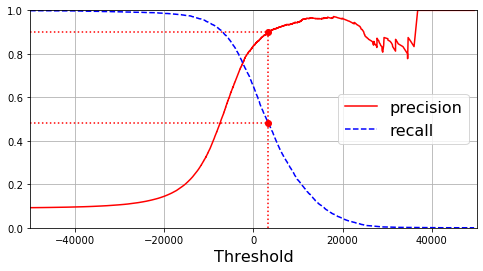

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], label = 'precision', color = 'r')
    plt.plot(thresholds, recalls[:-1], 'b--', label = 'recall' )
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") #vertical dot line             
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") #horizontal dot line(upper)                               
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") #horizontal dot line(lower)
plt.plot([threshold_90_precision], [0.9], "ro") #upper point                                              
plt.plot([threshold_90_precision], [recall_90_precision], "ro") #lower point                            
plt.show()

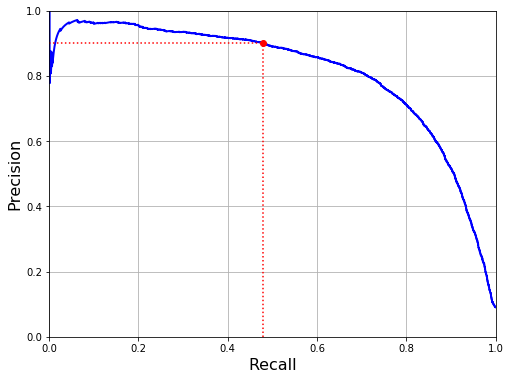

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision


3370.0194991439557

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## ROC curve

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)


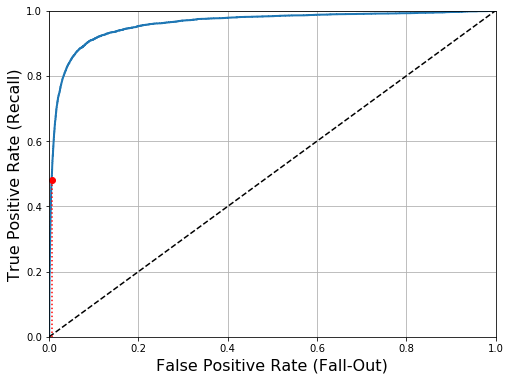

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [33]:
y_scores_forest = y_forest[:, 1] #positive prediction
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

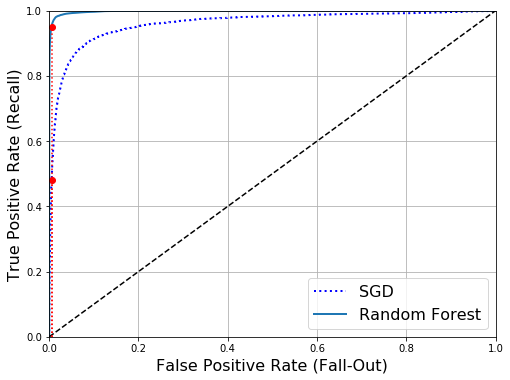

In [34]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Precision&Recall Curve? or ROC?
PR curve is preferred when (1)positive class is sparse or (2)false positive is more important than false negative. Else, ROC curve is used. For example, roc curve above implies that sgd is good classifier. However this result arose due to the asymmetric data.

# Multiclass Classifier
* SGD, randomforest, naive bayes, multinomial classifier can classify multiclass directly.
* logistic regression, support vector machine cannot classify multiclass directly. They can classify multiclass using multiple binary classifiers.

## OvR vs OvO (for binary classifier)
* Most binary algorithms prefer OvR. (# of classifiers = n, use whole sample when train each classifier)
* Since SVM is very sensitive to the scale of traing set, OvO is preferred. (# of classifiers = n(n-1) / 2, use sample labeld as two targets when train each classifier )

Since training whole set takes too much time, we use only some samples here

In [9]:
from sklearn.svm import SVC

svc_clf = SVC() #basically use OvR
svc_clf.fit(X_train[:5000], y_train[:5000]) # not y_train_5
svc_clf.predict([sample_digit])

array([5], dtype=uint8)

In [10]:
sample_score = svc_clf.decision_function([sample_digit])
sample_score

array([[ 0.74425472,  2.744763  ,  6.1874606 ,  8.29544346, -0.3001552 ,
         9.30508656,  1.74544703,  4.79018461,  7.19991924,  3.84775475]])

In [11]:
print(np.argmax(sample_score))
print(svc_clf.classes_)
print(svc_clf.classes_[np.argmax(sample_score)])

5
[0 1 2 3 4 5 6 7 8 9]
5


### Time Comparison

In [17]:
from sklearn.multiclass import OneVsOneClassifier
import time

start_time_ovo = time.time()

ovo_clf = OneVsOneClassifier(SVC())
ovo_clf.fit(X_train[:5000], y_train[:5000])
print(len(ovo_clf.estimators_))
print('Spent time: {0}'.format(time.time() - start_time_ovo))
ovo_clf.predict([sample_digit])

45
Spent time: 21.945343494415283


array([5], dtype=uint8)

In [20]:
ovo_clf.decision_function([sample_digit])

array([[ 0.74217874,  2.74439412,  6.18561599,  8.29579156, -0.29942965,
         9.30498661,  1.74566414,  4.78834404,  7.19731046,  3.84668364]])

In [18]:
from sklearn.multiclass import OneVsRestClassifier

start_time_ovr = time.time()

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train[:5000], y_train[:5000])
print(len(ovr_clf.estimators_))
print('Spent time: {0}'.format(time.time() - start_time_ovr))
ovr_clf.predict([sample_digit])

10
Spent time: 68.60304188728333


array([5], dtype=uint8)

In [19]:
ovr_clf.decision_function([sample_digit])

array([[-1.80470213, -2.04130221, -1.31879566, -0.95221122, -2.85577228,
         0.99962508, -1.83318569, -1.15119011, -2.06855338, -1.9673461 ]])

## Without OvR, OvO
SGD, Randomfrest do not require OvR, OvO. They can classifies multi classes on their own.

In [14]:
import time 

start_time_sgd = time.time()

sgd_clf.fit(X_train[:10000], y_train[:10000])
print('Spent time: {0}'.format(time.time() - start_time_sgd))

sgd_clf.predict([sample_digit])

Spent time: 21.663050651550293


array([5], dtype=uint8)

In [15]:
sgd_clf.decision_function([sample_digit])

array([[-353933.70144081, -456278.52453021, -118803.17830956,
          -9739.18440026, -380798.71504636,   37722.36441629,
        -361783.77920629, -252474.49554937, -142313.41302712,
        -199056.44166569]])

sgd model is suspecting 3 could be 5

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train[:10000], y_train[:10000], cv = 3, scoring = 'accuracy')

array([0.86592681, 0.86978698, 0.85448545])

<b>Better Model:</b>
Scaled train set improves the accuracy of model

In [21]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train[:10000].astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled[:10000], y_train[:10000], cv = 3, scoring = 'accuracy')

array([0.8920216 , 0.91029103, 0.88778878])

# Error Anaysis

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train[:10000], y_train[:10000], cv = 3)
conf_mat = confusion_matrix(y_train[:10000], y_train_pred)
conf_mat

array([[ 949,    0,    8,    7,    0,   12,    5,    3,   12,    5],
       [   0, 1049,   21,    9,    3,    8,    4,    4,   23,    6],
       [  10,   13,  834,   29,    5,    6,   19,   11,   51,   13],
       [   6,    3,   51,  854,    1,   54,    5,   14,   20,   24],
       [   1,    4,   18,    4,  843,    9,   10,   12,   11,   68],
       [  10,    6,   11,   45,   14,  692,   20,    5,   41,   19],
       [   7,    3,   16,    2,   12,   14,  939,    3,   13,    5],
       [   5,    1,   20,   17,   14,    2,    0,  924,    6,   81],
       [  10,   10,   43,   47,   10,   50,   16,   12,  715,   31],
       [   8,    4,    7,   24,   26,   11,    0,   56,    7,  835]],
      dtype=int64)

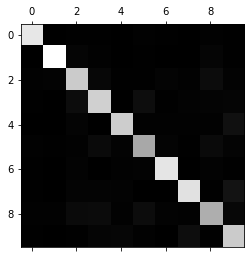

In [25]:
plt.matshow(conf_mat, cmap = plt.cm.gray)
plt.show()

Confusion matrix implies one of both possibilities: (1) my sgd model cannot distinguish number 5 as well as distinguishes other numbers (2) samples of 5 are less than other numbers

Then, convert the confusion matrix into the ratio measured confusion matrix.

In [30]:
norm_conf_mat

In [32]:
np.fill_diagonal(ratio_conf_mat, 0)

In [31]:
ratio_conf_mat

array([[0.        , 0.        , 0.00799201, 0.00699301, 0.        ,
        0.01198801, 0.004995  , 0.002997  , 0.01198801, 0.004995  ],
       [0.        , 0.        , 0.01863354, 0.0079858 , 0.00266193,
        0.00709849, 0.00354925, 0.00354925, 0.02040816, 0.00532387],
       [0.01009082, 0.01311806, 0.        , 0.02926337, 0.00504541,
        0.00605449, 0.01917255, 0.0110999 , 0.05146317, 0.01311806],
       [0.00581395, 0.00290698, 0.0494186 , 0.        , 0.00096899,
        0.05232558, 0.00484496, 0.01356589, 0.01937984, 0.02325581],
       [0.00102041, 0.00408163, 0.01836735, 0.00408163, 0.        ,
        0.00918367, 0.01020408, 0.0122449 , 0.01122449, 0.06938776],
       [0.01158749, 0.00695249, 0.01274623, 0.05214368, 0.01622248,
        0.        , 0.02317497, 0.00579374, 0.04750869, 0.02201622],
       [0.00690335, 0.00295858, 0.01577909, 0.00197239, 0.01183432,
        0.01380671, 0.        , 0.00295858, 0.01282051, 0.00493097],
       [0.0046729 , 0.00093458, 0.0186915

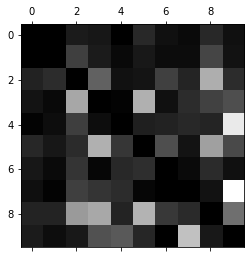

In [33]:
row_sums = conf_mat.sum(axis = 1, keepdims = True)
ratio_conf_mat = conf_mat / row_sums
np.fill_diagonal(ratio_conf_mat, 0)

plt.matshow(ratio_conf_mat, cmap = plt.cm.gray)
plt.show()

We can get insights why our classifier return incorrect results by investigating confusion matrix. Our model confuses 9 with 7. If we want to improve our model, more attributes will be helpful.

In [20]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

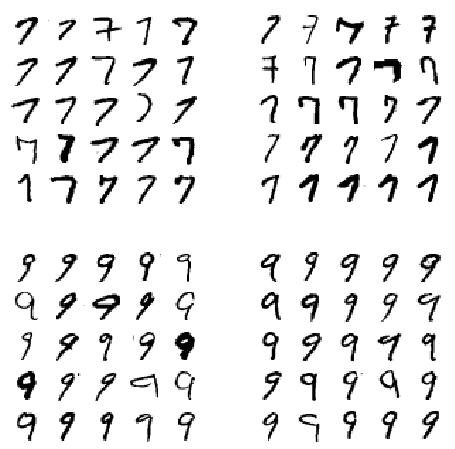

In [42]:
cl_a, cl_b = 7, 9
X_aa = X_train[:10000][(y_train[:10000] == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[:10000][(y_train[:10000] == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[:10000][(y_train[:10000] == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[:10000][(y_train[:10000] == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

Label can have multiple values. In this case, we examine two labels: Is the number big? Is the num odd?

In [11]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = ((y_train % 2) == 1)
y_train_multi = np.c_[y_train_large, y_train_odd]
y_train_multi

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [12]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train_multi)
kn_clf.predict([sample_digit]) #5 is not big and odd [False, True] is expected

array([[False,  True]])

## Evaluation
* average = 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
* average = 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.
* average = 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [16]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

y_kn_pred = cross_val_predict(kn_clf, X_train[:5000], y_train_multi[:5000], cv = 3)
print(f1_score(y_train_multi[:5000], y_kn_pred, average = 'macro'))
print(f1_score(y_train_multi[:5000], y_kn_pred, average = 'micro'))
print(f1_score(y_train_multi[:5000], y_kn_pred, average = 'weighted'))

0.9459349842547329
0.9492691315563199
0.9490944081744366


# Multioutput-multiclass Classification
System that eliminates noise is a sort of Multioutput-multiclass Classification with 784 labels.

In [18]:
noise = np.random.randint(1, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(1, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

restored image


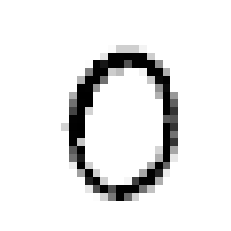

In [54]:
SOME_INDEX = 13

kn_clf.fit(X_train_mod, y_train_mod)
pred_mod = kn_clf.predict([X_test_mod[SOME_INDEX]])
print('restored image')
plot_digits(pred_mod)

origianl image


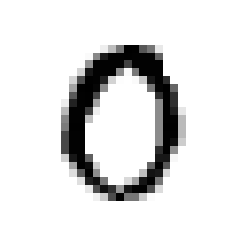

In [55]:
print('origianl image')
plot_digits([y_test_mod[SOME_INDEX]])

# Exercise
## Q1
Make a classifier using KNeighborsClassifier that achieves 97% accuracy

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

kn_clf = KNeighborsClassifier()

param_set = [
    {'n_neighbors': randint(1, 50), 'weights': ['uniform', 'distance']}
]

kn_clf_search = RandomizedSearchCV(estimator = kn_clf, param_distributions = param_set,
                   n_iter = 5, cv = 3, verbose = 2)
kn_clf_search.fit(X_train[:5000], y_train[:5000])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_neighbors=14, weights=distance ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
